Dentro de vs_release_16k.zip descomprimimos dos carpetas:  
- audio_16k  
- meta  

Nos servimos del módulo zipfile para descomprimir.  

In [2]:
import os
from zipfile import ZipFile

zip_file_name = "vs_release_16k.zip"
dirs_to_extract = ["audio_16k", "meta"]
output_dir = "data"

if not os.path.exists(output_dir):
    with ZipFile(zip_file_name, 'r') as zf:
        files_to_extract = [file for file in zf.namelist()
                            if any(file.startswith(dir) for dir in dirs_to_extract)]
        zf.extractall(path=output_dir, members=files_to_extract)

print(os.listdir(output_dir))

['audio_16k', 'meta']


Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:

In [3]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

def read_wav_file(wav_file):
    wave_name = os.path.basename(wav_file)
    wave_name = os.path.splitext(wave_name)[0]

    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)

    wave_array = np.frombuffer(frames, dtype=np.int16)

    return wave_name, wave_array, num_frames

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    df = pd.DataFrame(exe.map(read_wav_file, audio_paths), columns=['id', 'signal', 'frames'])

df.head()

,id,signal,frames
0,f0003_0_cough,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36...",66873
1,f0003_0_laughter,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ...",72818
2,f0003_0_sigh,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24...",56471
3,f0003_0_sneeze,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6...",54985
4,f0003_0_sniff,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ...",54985


Observación: Nuestros threads acceden a elementos distintos por tanto no hay problemas de race condition.

Mostramos un resultado con matplotlib:

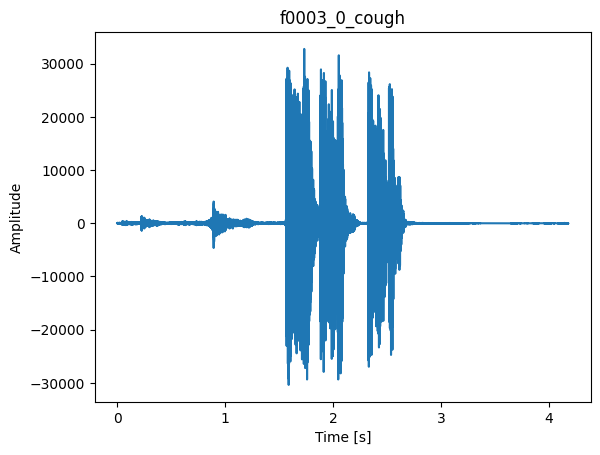

In [4]:
import matplotlib.pyplot as plt

name, signal, frames = df.iloc[0]

sample_rate = 16_000
duration = frames / sample_rate

x = np.linspace(0, duration, frames)
y = signal

plt.plot(x, y)
plt.title(name)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

Los nombres del archivo presentan una estructura:  
[sex] [id] \_ [index] \_ [class]  

- sex: m(male), f(female), o(other)  
- id: identificador del sujeto  
- index: índice, para un sujeto se puede tener más de una observación de la clase (class)  
(Ejemplo: si un sujeto tiene dos cough asociadas tendrán índices 0 y 1)  
- class: sonido vocal reproducido  
    - cough  
    - sniff  
    - sneeze  
    - sigh  
    - laughter  
    - throatclearing  

Crearemos nuevas columnas a partir de esta identificación de audio:

In [5]:
import re

pattern = r'([mfo])(\d+)_(\d+)_(\w+)'

def extract_info(string):
    match = re.match(pattern, string)
    
    sex = match.group(1)
    id = match.group(2)
    index = match.group(3)
    label = match.group(4)

    return pd.Series([sex, id, index, label])

df_std = df.copy()
df_std[['sex', 'id', 'index', 'label']] = df_std['id'].apply(extract_info)
df_std.head()

,id,signal,frames,sex,index,label
0,0003,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36...",66873,f,0,cough
1,0003,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ...",72818,f,0,laughter
2,0003,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24...",56471,f,0,sigh
3,0003,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6...",54985,f,0,sneeze
4,0003,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ...",54985,f,0,sniff


Tenemos 3504 observaciones de cada clase

In [6]:
df_std.groupby('label').size().to_frame(name='count')

,count
label,
cough,3504
laughter,3504
sigh,3504
sneeze,3504
sniff,3504
throatclearing,3504


Podemos también comprobar de media 

In [7]:
sample_rate = 16_000
avg_length = df_std.groupby('label')['frames'].mean().to_frame()
avg_length = (avg_length / sample_rate).rename(columns={'frames': 'avg_length(seconds)'})
avg_length

,avg_length(seconds)
label,
cough,4.571497
laughter,4.233145
sigh,4.562301
sneeze,3.848751
sniff,3.983074
throatclearing,3.843606


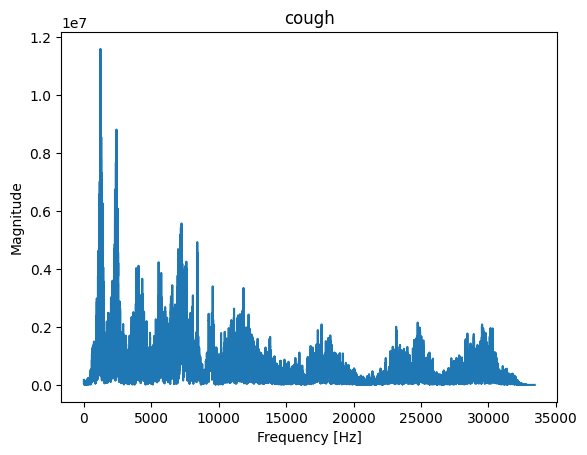

In [8]:
import matplotlib.pyplot as plt

label, signal = df_std[['label', 'signal']].iloc[0]
spectrum = np.fft.fft(signal)
spectrum = abs(spectrum) # magnitude for complex values
left_spectrum = spectrum[:int(len(spectrum) / 2)]

plt.plot(left_spectrum)
plt.title(label)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

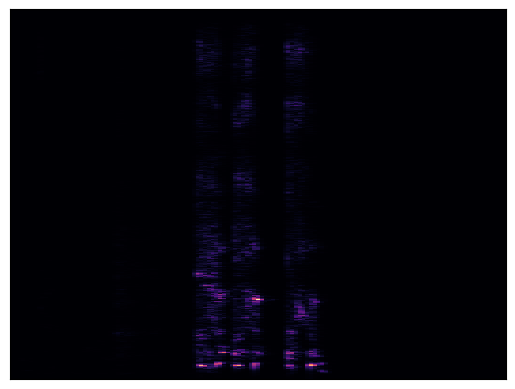

In [9]:
import librosa

label, signal = df_std[['label', 'signal']].iloc[0]

window = 2048 # number of samples per fft
shift = 512 # amount of samples shifted for the next fft

signal = signal.astype(float)
spectrogram = librosa.core.stft(signal, hop_length=shift, n_fft=window)
spectrogram = np.abs(spectrogram)

librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=shift)
plt.show()

Podemos utilizar una escala logarítmica para entender mejor el spectograma obtenido anteriormente que utilizaba una escala lineal.  
Las amplitudes lineales dadas en unidades lineales se pasan a decibelios utilizando la función **amplitude_to_db** de la librería librosa:  

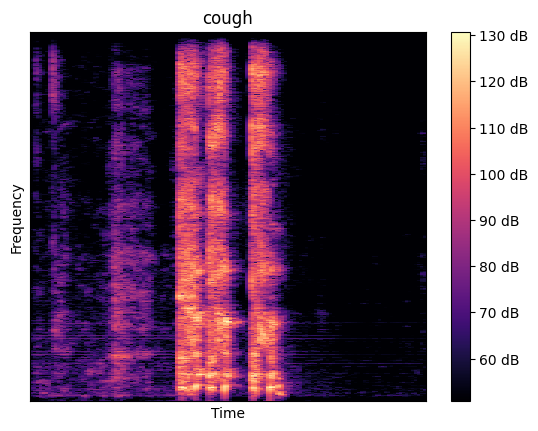

In [10]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure()
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=shift)

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title(label)
plt.colorbar(format="%2.0f dB")
plt.show()

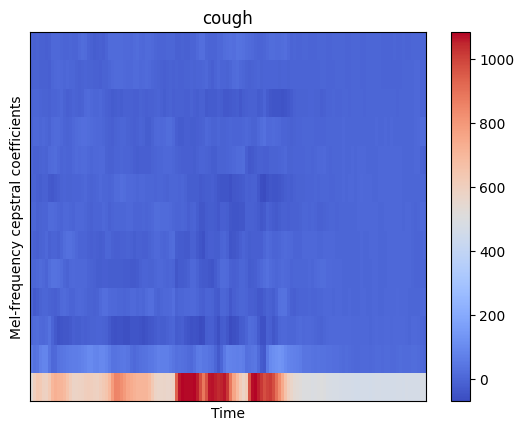

In [11]:
mfcc_spectrogram = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=window, hop_length=shift, n_mfcc=13)

plt.figure()
librosa.display.specshow(mfcc_spectrogram, sr=sample_rate, hop_length=shift)

plt.xlabel("Time")
plt.ylabel("Mel-frequency cepstral coefficients")
plt.title(label)
plt.colorbar()
plt.show()

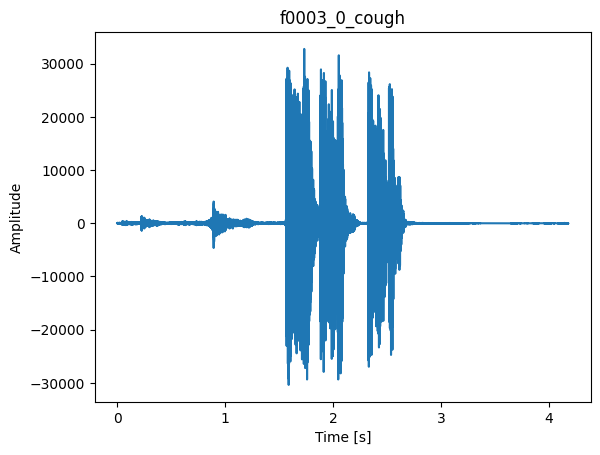

In [14]:
import matplotlib.pyplot as plt

label, signal, frames, *_ = df_std.iloc[0]

sample_rate = 16_000
duration = frames / sample_rate

x = np.linspace(0, duration, frames)
y = signal

plt.plot(x, y)
plt.title(name)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()